In [1]:
%load_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt
from skimage import io, transform, color
from colorize import network, util

In [2]:
net = network.Net()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
            Conv2d-2         [-1, 64, 112, 112]          36,928
       BatchNorm2d-3         [-1, 64, 112, 112]             128
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5          [-1, 128, 56, 56]         147,584
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
            Conv2d-9          [-1, 256, 28, 28]         590,080
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
           Conv2d-12          [-1, 512, 28, 28]       2,359,808
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
      BatchNorm2d-14          [-1, 512,

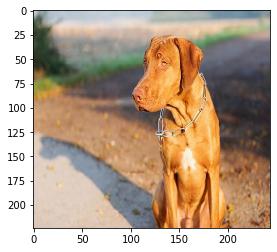

In [3]:
images = glob.glob("data/**/*.jpg")
for image in images:
    img = io.imread(image)
    img = transform.resize(img, (224, 244))
    plt.imshow(img)
    plt.show()
    lab = color.rgb2lab(img)
    break